In [1]:
import working_dir
working_dir.set_wd()

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
from src.dao import data_globals
from src.processing import entidade_urna
from src.utils import stats, dflib
from src.utils import pretties as prt

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
FILEPATH_PROC_ESTADOS = data_globals.FILEPATH_PROC_ESTADOS
FILEPATH_PROC_IBGE_SHAPEFILE = data_globals.FILEPATH_PROC_IBGE_SHAPEFILE
FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T = data_globals.FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T

# Carregando dados

## Estados

In [6]:
estados = pd.read_csv(FILEPATH_PROC_ESTADOS, sep=";")

cols_locais = ["ESTADO", "REGIAO", "CAPITAL"]

estados[cols_locais] = estados[cols_locais].apply(lambda col : col.str.upper())
estados[cols_locais] = estados[cols_locais].apply(lambda col: dflib.remove_acento_list(col.str.upper()))

estados.sample(5)

,SIGLA,ESTADO,REGIAO,CAPITAL
10,MT,MATO GROSSO,CENTRO OESTE,CUIABA
19,RN,RIO GRANDE DO NORTE,NORDESTE,NATAL
13,PA,PARA,NORTE,BELEM
21,RO,RONDONIA,NORTE,PORTO VELHO
20,RS,RIO GRANDE DO SUL,SUL,PORTO ALEGRE


## Boletins de Urna

In [7]:
DFBU_COLS = ['SG_UF', 'CD_MUNICIPIO', 'NM_MUNICIPIO', 
             'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', "NM_LOCAL_VOTACAO",
             'NR_PARTIDO', 'QT_APTOS', 'QT_COMPARECIMENTO', 'QT_ABSTENCOES',
             'DS_TIPO_VOTAVEL', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS',
             'NR_URNA_EFETIVADA', "modelo_urna"]

DFBU_DTYPE = {'SG_UF': str, 'CD_MUNICIPIO': str, 'NM_MUNICIPIO': str, 
              'NR_ZONA': str, 'NR_SECAO': str, 'NR_LOCAL_VOTACAO': str,
              'NR_PARTIDO': str, 'QT_APTOS': int, 'QT_COMPARECIMENTO': int, 'QT_ABSTENCOES': int,
              'DS_TIPO_VOTAVEL': str, 'NR_VOTAVEL': str, 'NM_VOTAVEL': str, 'QT_VOTOS': int,
              'NR_URNA_EFETIVADA': str, "modelo_urna": str}

In [8]:
CORES_CANDIDATOS = {"13": "#de0100", "22": "#1f5f5b"}

MODELO_URNA_BINARIO = {"2020": "modelo 2020", "2009": "modelo anterior", 
                       "2010": "modelo anterior", "2011": "modelo anterior", 
                       "2013": "modelo anterior", "2015": "modelo anterior"}

In [9]:
ESTADO = "Brasil"

In [10]:
dfbu = pd.read_csv(FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T, sep=";", encoding='latin1', 
                   usecols=DFBU_COLS, dtype=DFBU_DTYPE)

dfbu["modelo_urna_binario"] = dfbu["modelo_urna"].replace(MODELO_URNA_BINARIO)

if ESTADO != "Brasil":
    dfbu = dfbu[dfbu["SG_UF"] == ESTADO]

print("dfbu.shape", dfbu.shape)

dfbu.shape (1850891, 18)


In [11]:
dfbu.sample(5)

,SG_UF,CD_MUNICIPIO,NR_ZONA,NR_SECAO,NR_LOCAL_VOTACAO,NR_PARTIDO,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCOES,DS_TIPO_VOTAVEL,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_URNA_EFETIVADA,modelo_urna,NM_MUNICIPIO,NM_LOCAL_VOTACAO,modelo_urna_binario
936961,PE,25313,2,369,1597,22,324,290,34,Nominal,22,JAIR BOLSONARO,114,2040877,2020,RECIFE,ESCOLA PADRE JOSE MATHIAS DELGADO,modelo 2020
846801,PR,77771,14,250,1252,-1,398,341,57,Nulo,96,Nulo,11,2095748,2020,PONTA GROSSA,ESCOLA MUNICIPAL CORONEL CLAUDIO GONCALVES GUI...,modelo 2020
401216,GO,93890,132,639,1023,22,344,281,63,Nominal,22,JAIR BOLSONARO,135,2003240,2020,HIDROLANDIA,COLEGIO ESTADUAL DEPUTADO MANOEL MENDONCA,modelo 2020
166274,BA,34959,142,49,1163,22,337,292,45,Nominal,22,JAIR BOLSONARO,73,1231925,2010,CRUZ DAS ALMAS,CETEP ALBERTO TORRES,modelo anterior
632097,MG,48658,185,256,1090,-1,370,325,45,Nulo,96,Nulo,13,1835169,2015,MONTES CLAROS,ESCOLA ESTADUAL BELVINDA RIBEIRO,modelo anterior


# Tabela da entidade Urna Eletrônica
A variável dfu representa a votação a nível de Urna Eletrônica

In [12]:
index_urna = ["SG_UF", "NR_ZONA", "NR_SECAO", "CD_MUNICIPIO", "NR_LOCAL_VOTACAO", "NR_URNA_EFETIVADA", 
              "modelo_urna", "modelo_urna_binario", "NM_MUNICIPIO", "NM_LOCAL_VOTACAO"]

dfu = dfbu.pivot(columns="NR_VOTAVEL", values="QT_VOTOS", index=index_urna)
dfu = dfu.reset_index().rename(columns={"96": "Nulo", "95": "Branco"})
dfu.columns.name = None
dfu[["13", "22", "Branco", "Nulo"]] = dfu[["13", "22", "Branco", "Nulo"]].fillna(0).astype(int)

dfu.sample(8)

,SG_UF,NR_ZONA,NR_SECAO,CD_MUNICIPIO,NR_LOCAL_VOTACAO,NR_URNA_EFETIVADA,modelo_urna,modelo_urna_binario,NM_MUNICIPIO,NM_LOCAL_VOTACAO,13,22,Branco,Nulo
314106,RO,3,182,51,1422,2018478,2020,modelo 2020,JI-PARANA,PAULO FREIRE - ESCOLA MUNICIPAL,81,186,4,7
445668,SP,401,245,64157,1260,2166208,2020,modelo 2020,FERRAZ DE VASCONCELOS,INSTITUTO EDUCACIONAL LUTERANO,119,115,9,6
256817,PR,196,140,76813,1163,1172957,2009,modelo anterior,MANOEL RIBAS,ESCOLA RURAL MUNICIPAL SANTO INACIO,12,107,0,0
214866,PE,1,61,25313,1040,2221786,2020,modelo 2020,RECIFE,COLEGIO SANTA MARIA,99,206,8,7
443403,SP,397,108,71072,1112,2084554,2020,modelo 2020,SAO PAULO,EE. MARIA DE LOURDES VIEIRA,144,121,8,14
350866,SC,32,120,83577,1090,1285652,2010,modelo anterior,TIMBO,ESCOLA DE ENSINO FUNDAMENTAL PROFESSOR EMIR RO...,48,287,7,5
390801,SP,220,35,72435,1058,2211014,2020,modelo 2020,VOTORANTIM,EE. PROF. DANIEL VERANO,82,172,5,12
123098,MG,102,47,44458,1163,2127864,2020,modelo 2020,DIVINOPOLIS,ESCOLA ESTADUAL DONA ANTÃNIA VALADARES,113,164,3,9


,Absoluto,Relativo
2020,192691,0.408220
2010,93795,0.198707
2015,85735,0.181632
2009,48245,0.102208
2011,26889,0.056965
2013,24672,0.052268


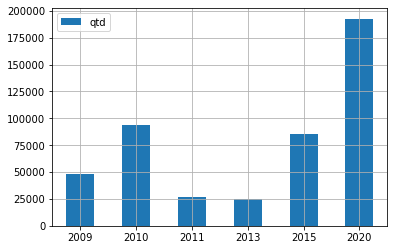

In [13]:
qtd_urnas = dfu["modelo_urna"].astype(str).value_counts().to_frame("qtd").sort_index()
prt.display(stats.freq(dfu["modelo_urna"].astype(str)))
qtd_urnas.plot.bar(rot=0, grid=True)
plt.show()

In [14]:
# SAO PAULO
# Jair Bolsonaro: 14.216.587 (55,24%) 
# Lula 11.519.882 (44,76%)

# PARAIBA
# Lula (PT): 66,62% dos votos válidos (1.601.953 votos)
# Jair Bolsonaro (PL): 33,38% dos votos válidos (802.502 votos)

# BRASIL
# Lula 60.345.999 votos (50,90% dos votos válidos)
# Jair Bolsonaro 58.206.354 votos (49,10% dos votos válidos).

votos_validos = dfu[["13", "22"]].sum().to_frame("votos")
votos_validos["%"] = votos_validos / votos_validos.sum()
prt.display(votos_validos)

,votos,%
13,60345999,0.509024
22,58206354,0.490976


# <font color='magenta'>Distribuição de Modelos de Urna</font>

In [15]:
modelos_cidade = dfu.groupby(["SG_UF", "NM_MUNICIPIO"]).apply(lambda g : stats.freq(g["modelo_urna_binario"])).reset_index().rename(columns={"level_2": "modelo_urna_binario"})

print("Cidades com 100% de urnas do mesmo modelo")
prt.display(stats.freq(modelos_cidade["Relativo"] == 1.0))
prt.hr()
prt.display(modelos_cidade.sample(8))

Cidades com 100% de urnas do mesmo modelo


,Absoluto,Relativo
True,5398,0.896678
False,622,0.103322


,SG_UF,NM_MUNICIPIO,modelo_urna_binario,Absoluto,Relativo
39,AL,CAMPO GRANDE,modelo anterior,24,1.0
4032,RS,CAPIVARI DO SUL,modelo anterior,11,1.0
665,CE,CATUNDA,modelo anterior,30,1.0
3667,RJ,QUISSAMA,modelo anterior,55,1.0
4155,RS,ITAARA,modelo 2020,14,1.0
2690,PB,MATARACA,modelo anterior,25,1.0
1479,MG,CAMPO AZUL,modelo anterior,16,1.0
3765,RN,LAGOA D'ANTA,modelo 2020,18,1.0


In [16]:
df_gpd = gpd.read_file(FILEPATH_PROC_IBGE_SHAPEFILE)

if ESTADO != "Brasil":
    df_gpd = df_gpd[df_gpd["SIGLA"] == ESTADO]
    

print("Cidades brasileiras da base do TSE que estão na base de shapefile")
prt.display(stats.freq(modelos_cidade[modelos_cidade["SG_UF"] != "ZZ"]["NM_MUNICIPIO"].isin(df_gpd["NM_MUN"].str.upper())))

print("Nomes de cidade no TSE que não estão no Shapefile")
prt.display(modelos_cidade[(~modelos_cidade["NM_MUNICIPIO"].isin(df_gpd["NM_MUN"].str.upper())) & 
                           (modelos_cidade["SG_UF"] != "ZZ")].sort_values("NM_MUNICIPIO"))
print()
print("modelos_cidade.shape", modelos_cidade.shape)
modelos_gpd = modelos_cidade.merge(df_gpd[["NM_MUN", "SIGLA", "AREA_KM2", "geometry"]], 
                                   left_on=["NM_MUNICIPIO", "SG_UF"], 
                                   right_on=["NM_MUN", "SIGLA"], 
                                   how="left").drop(["NM_MUN", "SIGLA"], axis=1)
print("modelos_cidade.shape", modelos_cidade.shape)
modelos_gpd = modelos_gpd.merge(estados, how="left",
                                left_on=["SG_UF"], right_on=["SIGLA"])
print("modelos_cidade.shape", modelos_cidade.shape)

modelos_gpd = gpd.GeoDataFrame(modelos_gpd)
prt.display(modelos_gpd.sample(min(5, len(modelos_gpd))))

Cidades brasileiras da base do TSE que estão na base de shapefile


,Absoluto,Relativo
True,5880,0.99983
False,1,0.00017


Nomes de cidade no TSE que não estão no Shapefile


,SG_UF,NM_MUNICIPIO,modelo_urna_binario,Absoluto,Relativo
3714,RN,BOA SAUDE,modelo 2020,25,1.0



modelos_cidade.shape (6020, 5)
modelos_cidade.shape (6020, 5)
modelos_cidade.shape (6020, 5)


,SG_UF,NM_MUNICIPIO,modelo_urna_binario,Absoluto,Relativo,AREA_KM2,geometry,SIGLA,ESTADO,REGIAO,CAPITAL
762,CE,PEREIRO,modelo anterior,57,1.0,435.868,"POLYGON ((-38.47292 -5.77846, -38.47157 -5.778...",CE,CEARA,NORDESTE,FORTALEZA
4091,RS,EREBANGO,modelo anterior,8,1.0,152.793,"POLYGON ((-52.29997 -27.74871, -52.29822 -27.7...",RS,RIO GRANDE DO SUL,SUL,PORTO ALEGRE
4898,SP,BARRA DO TURVO,modelo anterior,24,1.0,1007.684,"POLYGON ((-48.43697 -24.65320, -48.43658 -24.6...",SP,SAO PAULO,SUDESTE,SAO PAULO
2379,MT,PARANATINGA,modelo anterior,51,1.0,24166.632,"POLYGON ((-53.54667 -11.95053, -53.54629 -11.9...",MT,MATO GROSSO,CENTRO OESTE,CUIABA
4149,RS,IMIGRANTE,modelo anterior,8,1.0,71.716,"POLYGON ((-51.71531 -29.29697, -51.71323 -29.3...",RS,RIO GRANDE DO SUL,SUL,PORTO ALEGRE


Estado: Brasil


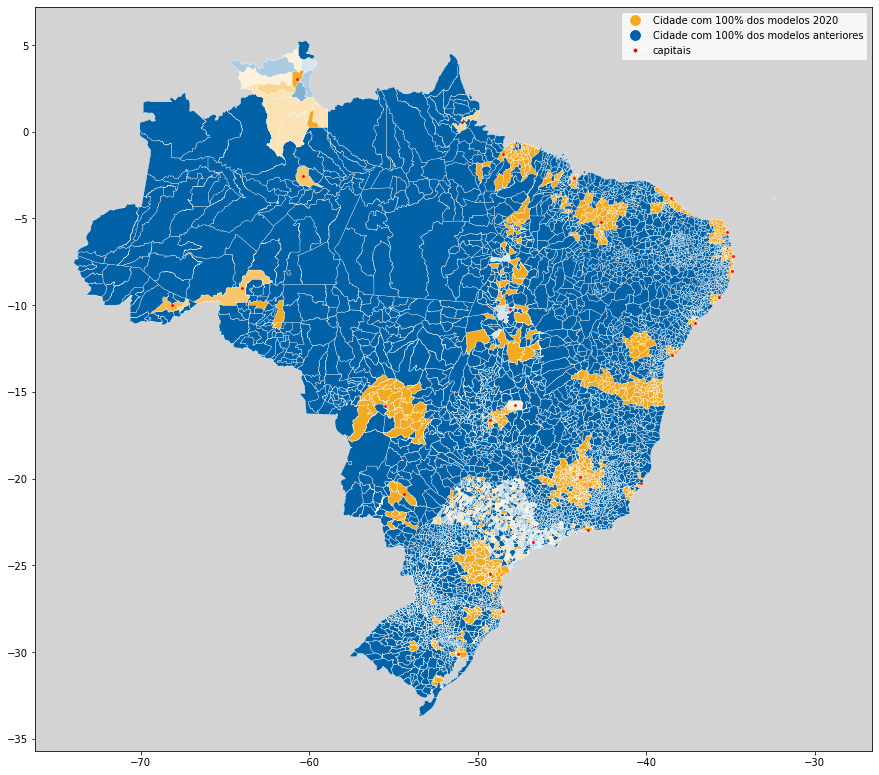

In [17]:
modelos_gpd["cor_gradiente_modelo_urna_bin"] = modelos_gpd.apply(lambda row : entidade_urna.cor_gradiente(row), axis=1)
modelos_gpd["cor_modelo_urna_bin"] = modelos_gpd["modelo_urna_binario"].replace(entidade_urna.COLOR_MODELO_URNA_BIN)
modelos_gpd_cores = modelos_gpd[~modelos_gpd["cor_gradiente_modelo_urna_bin"].isna()]

capitais = modelos_gpd[modelos_gpd["NM_MUNICIPIO"] == modelos_gpd["CAPITAL"]].drop_duplicates(subset=["SG_UF", "NM_MUNICIPIO"])[["SG_UF", "NM_MUNICIPIO", "geometry"]].sort_values("SG_UF")

print(f"Estado: {ESTADO}")

modelos_gpd_cores_not_na = modelos_gpd_cores.dropna(subset=["geometry"])

if ESTADO == "Brasil":
    linewidth = 0.3
else:
    linewidth = 0.50

p = modelos_gpd_cores_not_na.plot(color=modelos_gpd_cores_not_na["cor_gradiente_modelo_urna_bin"], 
                                  figsize=(15,15), linewidth=linewidth, edgecolor="white")

capitais.representative_point().plot(ax=p, marker='.', color='red', markersize=12);

p.set_facecolor('lightgray')

line1 = Line2D([], [], color="white", marker='o', markersize=12, 
               markerfacecolor=entidade_urna.COLOR_MODELO_URNA_BIN["modelo 2020"])
line2 = Line2D([], [], color="white", marker='o', markersize=12, 
               markerfacecolor=entidade_urna.COLOR_MODELO_URNA_BIN["modelo anterior"])
line3 = Line2D([], [], color="white", marker='.', markersize=10, 
               markerfacecolor="red")

plt.legend((line1, line2, line3), ("Cidade com 100% dos modelos 2020", 
                                   "Cidade com 100% dos modelos anteriores", 
                                   "capitais"), numpoints=1, loc=1)

plt.show()